In [3]:
import numpy as np
import subtractr
import subtractr.utils as utils
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
from jax import jit, vmap

from subtractr.low_rank import _svd_init
from jax.experimental import loops

from subtractr.low_rank import _nmu, coordinate_descent_nmu, _rank_one_nmu_decreasing
import jax.numpy as jnp
from sklearn.isotonic import IsotonicRegression
from functools import partial

jax.config.update("jax_enable_x64", True)

In [2]:
pscs, stim_mat, powers, targets = utils.load_h5_data('../data/marta/targeted_opsin_positive/preprocessed/cell7_emx_map_221214_cmFormat.mat')

In [3]:
idxs = np.argsort(pscs[:, 100:160].sum(axis=1))[::-1]
pscs = pscs[idxs, :]

In [91]:
import subtractr.low_rank as lr

def _nonnegsvd_init(traces, rank=1):
    U, S, V = jnp.linalg.svd(traces, full_matrices=False)
    U = U[:, :rank] * S[:rank]
    V = V[:rank, :]

    U_plus = jnp.maximum(U, 0)
    U_minus = jnp.maximum(-U, 0)
    V_plus = jnp.maximum(V, 0)
    V_minus = jnp.maximum(-V, 0)

    U = jnp.zeros_like(U)
    V = jnp.zeros_like(V)
    for i in range(rank):
        # Rewrite the above using jax.lax.cond
        U = U.at[:, i:i+1].set(
            jax.lax.cond(
                jnp.linalg.norm(
                    U_plus[:, i:i+1] @ V_plus[i:i+1, :]) > jnp.linalg.norm(
                        U_minus[:, i:i+1] @ V_minus[i:i+1, :]),
                lambda x: U_plus[:, i:i+1],
                lambda x: U_minus[:, i:i+1],
                None
            )
        )
        V = V.at[i:i+1, :].set(
                jax.lax.cond(
                jnp.linalg.norm(
                    U_plus[:, i:i+1] @ V_plus[i:i+1, :]) > jnp.linalg.norm(
                        U_minus[:, i:i+1] @ V_minus[i:i+1, :]),
                lambda x: V_plus[i:i+1, :],
                lambda x: V_minus[i:i+1, :],
                None
            )
        )

    return U, V

def coordinate_descent_nmu(traces,
                           const_baseline=True,
                           decaying_baseline=True,
                           rank=1,
                           update_U=True,
                           update_V=True,
                           max_iters=100,
                           tol=1e-4,
                           gamma=0.99,
                           v_start_idx=0,
                           init_factors=None):


    if init_factors:
        beta, U, V = init_factors
    else:
        if decaying_baseline:
            U, V = _nonnegsvd_init(traces, rank=rank+1)
            V = V.at[1:, 0:v_start_idx].set(0)
        else:
            U, V = _nonnegsvd_init(traces, rank=rank)
            V = V.at[:, 0:v_start_idx].set(0)

        if const_baseline:
            beta = jnp.min(traces, axis=1, keepdims=True)
        else:
            beta = jnp.zeros((traces.shape[0], 1))

    loss = jnp.zeros(max_iters)
    for i in range(max_iters):
        if const_baseline:
            beta = jnp.min(traces - U @ V, axis=1, keepdims=True)
            beta = jnp.maximum(beta, 0)
        
        resid_minus_beta = traces - beta

        for r in range(rank):
            u_curr, v_curr = U[:, r:r+1], V[r:r+1, :]
            resid = resid_minus_beta - U @ V + u_curr @ v_curr

            # treat first component differently if enforcing decaying baseline
            if decaying_baseline and r == 0:
                u_i, v_i, _ = lr._rank_one_nmu_decreasing(resid, (u_curr, v_curr), 
                    gamma=gamma, update_U=update_U, update_V=update_V)
            else:
                u_i, v_i, _, _ = lr._rank_one_nmu(resid, (u_curr, v_curr),
                    update_U=update_U, update_V=update_V)
                v_i = v_i.at[:, 0:v_start_idx].set(0)

            U = U.at[:, r:r+1].set(u_i)
            V = V.at[r:r+1, :].set(v_i)

        loss = loss.at[i].set(jnp.linalg.norm(traces - U @ V - beta))
    
    return U, V, beta, loss

def coordinate_descent_photocurrents(traces, rank=1, gamma=0.999, stim_start=100, stim_end=200):
    U_stim, V_stim, beta, loss = coordinate_descent_nmu(
        traces[:, 0:stim_end], const_baseline=True, 
        update_U=True, update_V=True,
        decaying_baseline=True, rank=rank, gamma=gamma,
        max_iters=20,
        v_start_idx=stim_start)
    V_full_init = jnp.linalg.lstsq(U_stim, traces)[0]
    _, V_full, _, _ = coordinate_descent_nmu(
        traces, const_baseline=False,
        update_U=False, update_V=True,
        decaying_baseline=True,
        rank=rank, gamma=gamma,
        max_iters=20,
        v_start_idx=0,
        init_factors=(beta, U_stim, V_full_init))

    return beta, U_stim, V_full
    
    
    

In [92]:
traces = pscs[0:100, :]
traces = np.maximum(traces, 0)
# U, V, beta, loss = coordinate_descent_nmu(
#     traces, const_baseline=True, decaying_baseline=True, rank=2, gamma=0.999, max_iters=20,
#     v_start_idx=100)
beta, U, V = coordinate_descent_photocurrents(traces, rank=2, gamma=0.999, stim_start=100, stim_end=200)

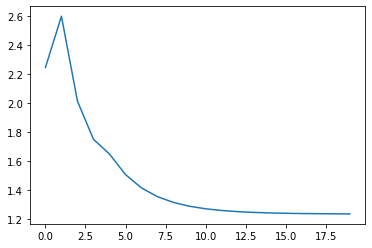

In [93]:
plt.plot(loss)

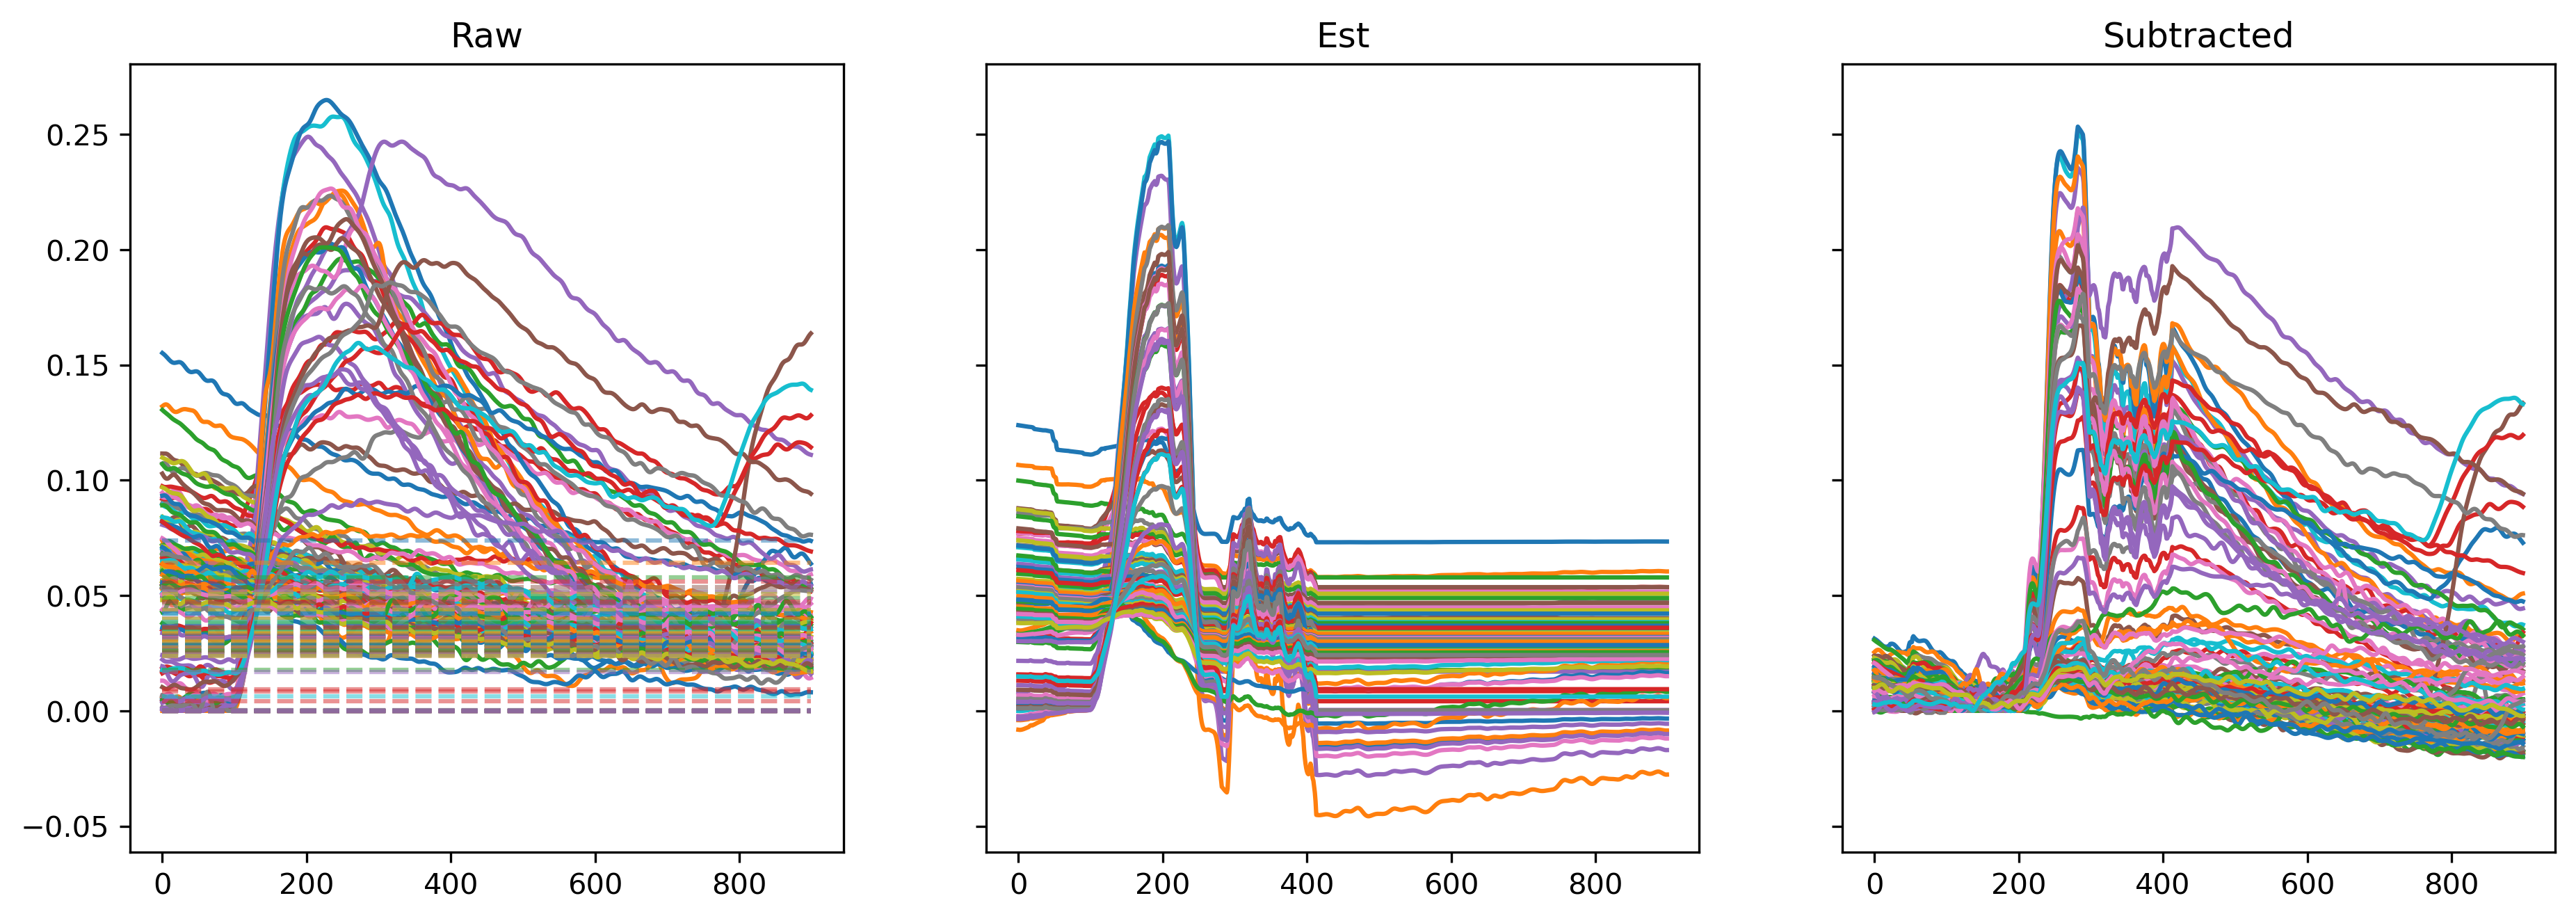

In [94]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), dpi=300, facecolor='white', sharey=True)
axs[0].plot(traces.T)
axs[0].plot((beta * np.ones_like(traces)).T, '--', alpha=0.5)
axs[0].set_title('Raw')

axs[1].plot((U @ V + beta).T)
axs[1].set_title('Est')

axs[2].plot((traces - U @ V - beta).T)
axs[2].set_title('Subtracted')
plt.show()

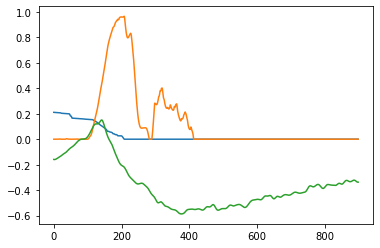

In [95]:
plt.plot(V.T)

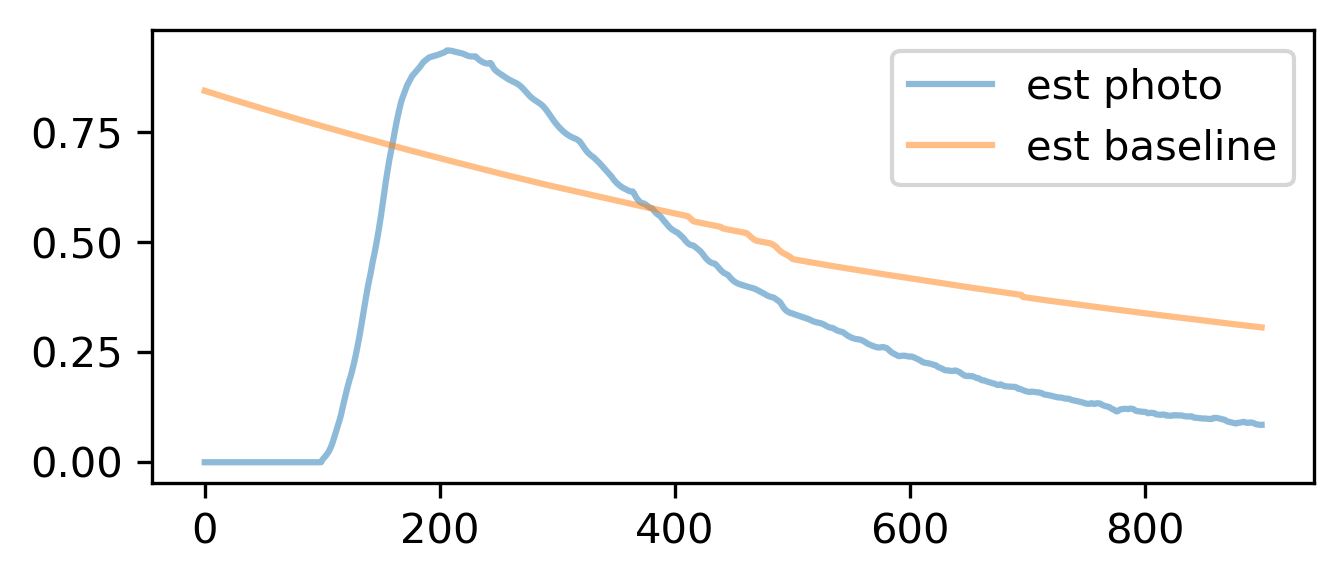

In [210]:
plt.figure(figsize=(5, 2), dpi=300)
plt.plot(V[0], label='est photo', alpha=0.5)
plt.plot(V[2], label='est baseline', alpha=0.5)
plt.legend()

In [211]:
pscs, stim_mat, powers, targets = utils.load_h5_data('../data/marta/targeted_opsin_positive/preprocessed/cell8_vc_emx_map_221219_cmFormat.mat')
idxs = np.argsort(pscs[:, 100:160].sum(axis=1))[::-1]
pscs = pscs[idxs, :]

In [212]:
batch_start_idx = 200
batch_end_idx = 300
batch = pscs[batch_start_idx:batch_end_idx, :]
U, V, beta = estimate_photocurrents_nmu_extended_baseline(batch, rank=1, gamma=0.999)

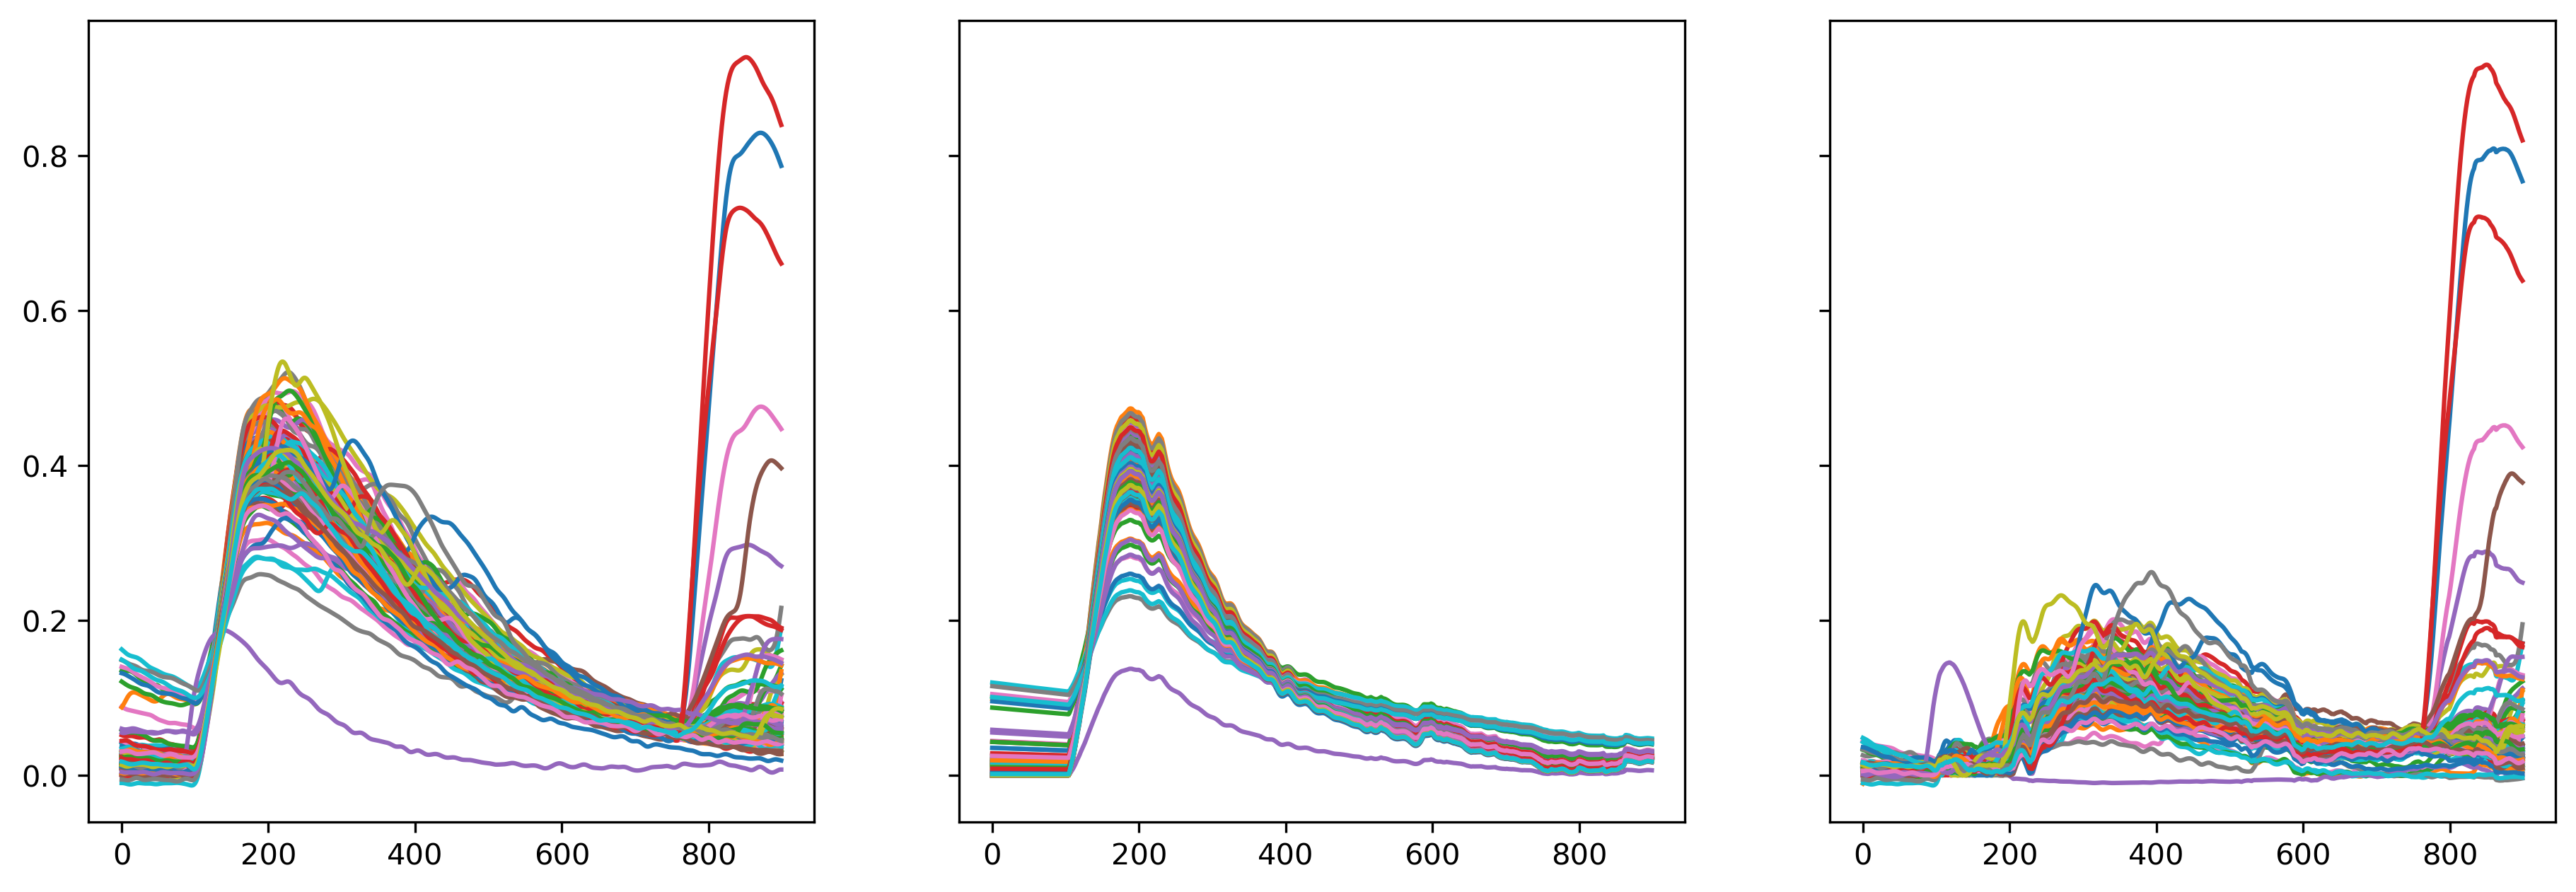

In [213]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), dpi=300, facecolor='white', sharey=True)
axs[0].plot(batch.T)
axs[1].plot((U @ V + beta).T)
axs[2].plot((batch - U @ V - beta).T)
plt.show()

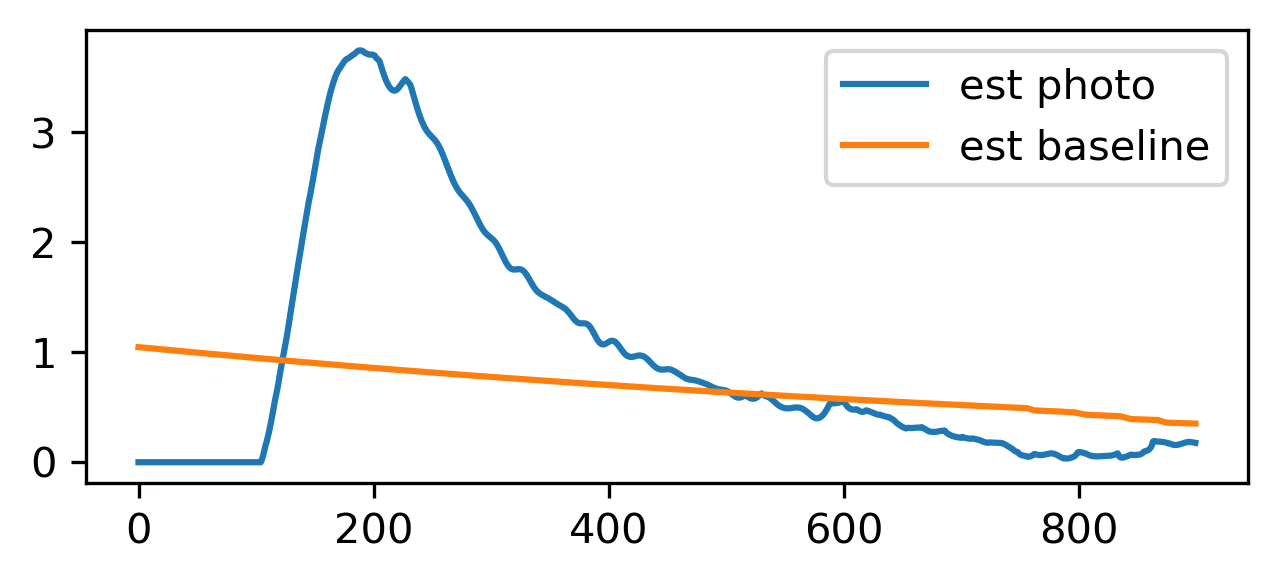

In [189]:
plt.figure(figsize=(5, 2), dpi=300)
plt.plot(V[0], label='est photo')
plt.plot(V[1], label='est baseline')
plt.legend()

## Add decay after certain timepoint

In [23]:
from subtractr.pava import pava_decreasing

def _rank_one_nmu_decreasing(traces, init_factors,
                             update_U=True, update_V=True,
                             dec_start=0, # index where we enforce the constraint
                             maxiter=5000, tol=1e-2, rho=1.0, gamma=1.0):
    """Non-negative matrix underapproximation with rank 1 using ADMM

    Init factors must be passed as a tuple of U and V matrices, due to the way JAX handles
    optional arguments. If init_factors_contains NaN, override with SVD initialization.

    Parameters
    ----------
    traces : array-like
        Traces to estimate photocurrents from. Shape is (n_traces, n_timepoints).
    init_factors : tuple of array-like
        Initial U and V matrices. Shape is (n_traces, rank) and (rank, n_timepoints).
    update_U : bool
        If True, update U.
    update_V : bool
        If True, update V.
    maxiter : int
        Maximum number of iterations.
    tol : float
        Tolerance for convergence.
    rho : float
        ADMM penalty parameter.
    init_factors : tuple of array-like
        Initial U and V matrices. Shape is (n_traces, rank) and (rank, n_timepoints).
        If None, initialize using SVD.

    Returns
    -------
    U : array-like
        U matrix. Shape is (n_traces, rank).
    V : array-like
        V matrix. Shape is (rank, n_timepoints).
    beta : array-like
        Baseline term. Shape is (n_traces, 1).
    max_violation : array-like
        Maximum violation of non-underapprox constraint at each iteration.
    """
    U, V = init_factors
    U, V = jax.lax.cond(
        jnp.any(jnp.isnan(U @ V)),
        lambda _: _svd_init(traces),
        lambda _: init_factors,
        None
    )

    Gamma = jnp.zeros_like(traces)
    lam = jnp.zeros_like(V)
    q = V.copy()
    R = jnp.maximum(0, traces - U @ V)
    U_old = U.copy() + 10 * tol
    V_old = V.copy() + 10 * tol
    k = 0
    max_violation = jnp.zeros(maxiter) * jnp.nan
    val = (U, V, q, lam, U_old, V_old, R, Gamma, k, max_violation)

    # NB: Beta is a placeholder for now -- not actually implemented.
    # This allows us to have the same function signature as _rank_one_nmu.
    beta = jnp.zeros((traces.shape[0], 1))

    def _convergence_tol_check(val):
        U, V, q, lam, U_old, V_old, R, Gamma, k, max_violation = val
        return jnp.any(jnp.array([
            (jnp.linalg.norm(U - U_old) / jnp.linalg.norm(U_old) > tol),
            (jnp.linalg.norm(V - V_old) / jnp.linalg.norm(V_old) > tol),
            (jnp.linalg.norm(V - q) > tol),
            jnp.min(traces - U @ V) < -tol,
        ]))

    def _not_converged(val):
        U, V, q, lam, U_old, V_old, R, Gamma, k, max_violation = val
        return jax.lax.cond(
            k < maxiter,
            lambda _: _convergence_tol_check(val),
            lambda _: False,
            None
        )

    def _update(val):
        U, V, q, lam, U_old, V_old, R, Gamma, k, max_violation = val
        U_old = U.copy()
        V_old = V.copy()
        M = traces - R + Gamma / rho
        resid = traces - U @ V
        if update_U:
            U = M @ V.T
            U = jnp.maximum(0, U)
            U = jax.lax.cond(
                jnp.all(U <= 1e-10),
                lambda _: U * 0.0,
                lambda _: U / jnp.linalg.norm(U),
                None,
            )
        if update_V:

            # update V
            V = (U.T @ (Gamma + rho * (traces - R)) +
                 lam + rho * q) / (rho * (U.T @ U + 1))
            V = jnp.maximum(0, V)

            # update auxiliary variable q
            q = jnp.zeros_like(V)
            q = q.at[0,0:dec_start].set((V - lam / rho)[0,0:dec_start])
            q = q.at[0,dec_start:].set(
                pava_decreasing(jnp.squeeze(V - lam / rho)[dec_start:], gamma=gamma)
            )
            
            # update lagrange multiplier
            lam = lam + rho * (q - V)

        R = 1 / (1 + rho) * (rho * resid + Gamma)
        R = jnp.maximum(0, R)
        Gamma = Gamma + rho * (resid - R)
        max_violation = max_violation.at[k].set(jnp.min(traces - U @ V))
        k += 1
        return (U, V, q, lam, U_old, V_old, R, Gamma, k, max_violation)
    val = jax.lax.while_loop(
        _not_converged,
        _update,
        val,
    )
    (U, V, q, lam, U_old, V_old, R, Gamma, k, max_violation) = val

    return U, V, beta, max_violation

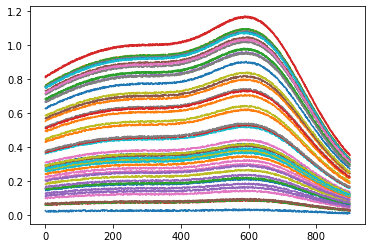

In [24]:
N = 50
T = 900
time = np.linspace(-20,50, num=T)
sigma = 1
v = np.exp(-(time**2) / 2000) + 0.5 * np.exp(-(time-30)**2 / 200)
u = np.random.rand(N)

X_sim = np.outer(u,v) + np.random.rand(N,T) * 0.01
plt.plot(X_sim.T)

u_init, v_init = np.zeros((N,1)) * np.nan, np.zeros((1,T)) * np.nan
U_est, V_est, max_violation, q = _rank_one_nmu_decreasing(X_sim, (u_init, v_init), 
gamma=0.995, dec_start=500, maxiter=10000, rho=1.0)

In [132]:
U_est, V_est, max_violation, = _rank_one_nmu_decreasing(X_sim, (u_init, v_init), 
gamma=0.995, dec_start=700, maxiter=10000, rho=10.0)
obj = np.linalg.norm(X_sim - U_est @ V_est, ord='fro')
print(obj)

60.64002305544521
